In [1]:

# Import pandas numpy, sqlite3, seaborn, matplotlib, scipy, statsmodels, wave, ffmpeg
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import spectrogram
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.proportion import proportion_confint
import scipy.stats as stats 
from itertools import combinations
import ipywidgets as widgets
from IPython.display import display
import wave
import ffmpeg
from IPython.display import Audio

In [2]:
# Import Kagglehub API and get data
import kagglehub

# Download latest version
path = kagglehub.dataset_download("catherinerasgaitis/mxmh-survey-results")

print("Path to dataset files:", path)

Path to dataset files: /Users/luckyc/.cache/kagglehub/datasets/catherinerasgaitis/mxmh-survey-results/versions/1


In [3]:
# Create a dataframe from CSV obtained in kagglehub API for survey results 
survey = pd.read_csv("mxmh_survey_results.csv")

# Show first two lines
survey.head(2)

,Timestamp,Age,Primary streaming service,Hours per day,While working,Instrumentalist,Composer,Fav genre,Exploratory,Foreign languages,...,Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety,Depression,Insomnia,OCD,Music effects,Permissions
0,8/27/2022 19:29:02,18.0,Spotify,3.0,Yes,Yes,Yes,Latin,Yes,Yes,...,Sometimes,Very frequently,Never,Sometimes,3.0,0.0,1.0,0.0,NaN,I understand.
1,8/27/2022 19:57:31,63.0,Pandora,1.5,Yes,No,No,Rock,Yes,No,...,Sometimes,Rarely,Very frequently,Rarely,7.0,2.0,2.0,1.0,NaN,I understand.


In [4]:
# reading in survey data manipulated in sql to have columns wanted
survey_sql = pd.read_csv("mxmh_survey.csv")

# Show the first two lines
survey_sql.head(2)

,Age,Primarystreamingservice,Favgenre,BPM,Anxiety,Depression,Insomnia,OCD,Musiceffects
0,18.0,spotify,latin,156.0,3.0,0.0,1.0,0.0,NaN
1,18.0,spotify,video game music,132.0,7.0,7.0,10.0,2.0,No effect


In [5]:
# Check for isnull
survey_sql.isnull().any().any()

np.True_

In [6]:
# Checking where isnull values are located
survey_sql.isnull().sum()

Age                         1
Primarystreamingservice     0
Favgenre                    0
BPM                        56
Anxiety                     0
Depression                  0
Insomnia                    0
OCD                         0
Musiceffects                3
dtype: int64

In [7]:
# removing isnull items and reseting index as well and renaming with _cleaned
survey_sql_cleaned = survey_sql.dropna().reset_index(drop=True)

In [8]:
survey_sql_cleaned.head(2)

,Age,Primarystreamingservice,Favgenre,BPM,Anxiety,Depression,Insomnia,OCD,Musiceffects
0,18.0,spotify,video game music,132.0,7.0,7.0,10.0,2.0,No effect
1,18.0,spotify,r&b,107.0,7.0,2.0,5.0,9.0,Improve


In [9]:
# reading in survey data manipulated in sql to have columns wanted
survey_db_counts = pd.read_csv('survey_db_update.csv')

# Show the first two lines
survey_db_counts.head(2)


,Primarystreamingservice,Favgenre,improve_count,worsen_count,no_effect_count,total_count
0,spotify,classical,17,1,7,25
1,spotify,country,12,0,3,15


In [10]:
# checking for null

survey_db_counts.isnull().any().any() 

np.False_

In [11]:

# calulate the percentage of improve count, worsen count, and no effect count against total count
def calculate_percentage(survey_db_counts):
    # Calculate percentages
    survey_db_counts['improve_percentage'] = ((survey_db_counts['improve_count'] / survey_db_counts['total_count']) * 100).round(2)
    survey_db_counts['worsen_percentage'] = ((survey_db_counts['worsen_count'] / survey_db_counts['total_count']) * 100).round(2)
    survey_db_counts['no_effect_percentage'] = ((survey_db_counts['no_effect_count'] / survey_db_counts['total_count']) * 100).round(2)

    # Return the DataFrame with the new columns
    return survey_db_counts[['Favgenre', 'total_count', 'improve_percentage', 'worsen_percentage', 'no_effect_percentage']]


In [12]:
# call the percentage function

percentages = calculate_percentage(survey_db_counts)

percentages

,Favgenre,total_count,improve_percentage,worsen_percentage,no_effect_percentage
0,classical,25,68.00,4.00,28.00
1,country,15,80.00,0.00,20.00
2,edm,21,80.95,0.00,19.05
3,folk,20,75.00,0.00,25.00
4,gospel,2,100.00,0.00,0.00
5,hip hop,28,92.86,0.00,7.14
6,jazz,15,86.67,0.00,13.33
7,k pop,22,72.73,0.00,18.18
8,latin,2,0.00,0.00,50.00
9,lofi,8,100.00,0.00,0.00


In [13]:
# using confidence intervals to determine if the data is statistically significant to state that one genre is better than other genres for moood

# Calculate the improve percentage for each genre
survey_db_counts['improve_percentage'] = (survey_db_counts['improve_count'] / survey_db_counts['total_count']) * 100

# Calculate the confidence intervals for each genre
confidence_results = []
for genre in survey_db_counts['Favgenre'].unique():
    genre_data = survey_db_counts[survey_db_counts['Favgenre'] == genre]
    number = genre_data['total_count'].sum()  
    successes = genre_data['improve_count'].sum()  

    # Calculate confidence intervals using the Wilson score interval --> this was recommended based on research
    lower, upper = proportion_confint(successes, number, alpha=0.05, method='wilson')
    
    # label/mark the results of confidence interval
    mean_percentage = (successes / number) * 100
    confidence_results.append((genre, mean_percentage, lower * 100, upper * 100))

# creating a dataframe for confidence interval (ci)
ci_survey = pd.DataFrame(confidence_results, columns=['Genre', 'Improve Percentage', 'Lower CI', 'Upper CI'])
ci_survey


,Genre,Improve Percentage,Lower CI,Upper CI
0,classical,68.000000,48.410269,82.794810
1,country,80.000000,54.814551,92.952451
2,edm,80.952381,59.999435,92.332435
3,folk,75.000000,53.129912,88.813830
4,gospel,100.000000,34.238023,100.000000
5,hip hop,92.857143,77.354637,98.018794
6,jazz,86.666667,62.118017,96.263874
7,k pop,72.727273,51.848266,86.849240
8,latin,0.000000,0.000000,65.761977
9,lofi,100.000000,67.559244,100.000000


Based on the confidence intervals lower and upper there is no way to state which genre has the best type of music that improves mental health. it is likely that whatever music you like to listen to improves your mood. As a result I will select the top 2 songs for each genre according to spotify


In [14]:
# Setting up for correlation matrix
survey_filtered_numeric = survey_sql_cleaned.select_dtypes(include=['number'])
# survey_filtered_numeric = survey_db_counts.select_dtypes(include=['number'])

# Correlation Matrix
corr_matrix_survey = survey_filtered_numeric.corr()

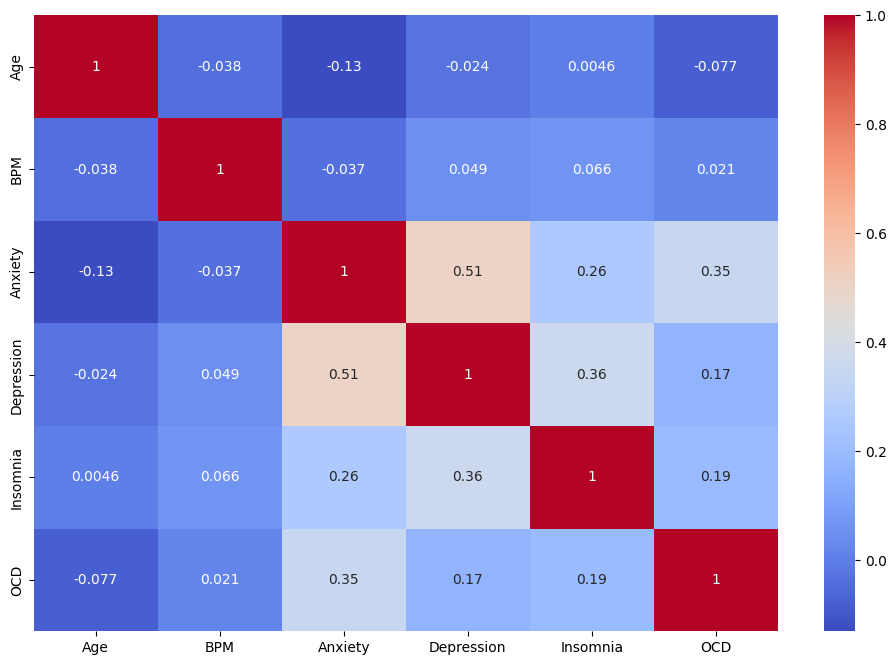

In [15]:
# Plot the heatmap  
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix_survey, annot=True, cmap='coolwarm')
plt.show()

Anxiety and depression show a high correlation

In [16]:
# Create a dataframe for high popularity spotify
high_spotify = pd.read_csv("high_popularity_spotify_data.csv")

# Show first two lines
high_spotify.head(2)

,energy,tempo,danceability,playlist_genre,loudness,liveness,valence,track_artist,time_signature,speechiness,...,instrumentalness,track_album_id,mode,key,duration_ms,acousticness,id,playlist_subgenre,type,playlist_id
0,0.592,157.969,0.521,pop,-7.777,0.122,0.535,"Lady Gaga, Bruno Mars",3,0.0304,...,0.0000,10FLjwfpbxLmW8c25Xyc2N,0,6,251668,0.308,2plbrEY59IikOBgBGLjaoe,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
1,0.507,104.978,0.747,pop,-10.171,0.117,0.438,Billie Eilish,4,0.0358,...,0.0608,7aJuG4TFXa2hmE4z1yxc3n,1,2,210373,0.200,6dOtVTDdiauQNBQEDOtlAB,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M


In [17]:
# Create a dataframe for low popularity spotify
low_spotify = pd.read_csv("low_popularity_spotify_data.csv")

# Show first two lines
low_spotify.head(2)

,time_signature,track_popularity,speechiness,danceability,playlist_name,track_artist,duration_ms,energy,playlist_genre,playlist_subgenre,...,track_album_id,playlist_id,track_id,valence,key,tempo,loudness,acousticness,liveness,track_album_name
0,4.0,23,0.0393,0.636,Rock Classics,Creedence Clearwater Revival,138053.0,0.746,rock,classic,...,4A8gFwqd9jTtnsNwUu3OQx,37i9dQZF1DWXRqgorJj26U,5e6x5YRnMJIKvYpZxLqdpH,0.432,0.0,132.310,-3.785,0.0648,0.1730,The Long Road Home - The Ultimate John Fogerty...
1,4.0,53,0.0317,0.572,Rock Classics,Van Halen,241600.0,0.835,rock,classic,...,2c965LEDRNrXXCeBOAAwns,37i9dQZF1DWXRqgorJj26U,5FqYA8KfiwsQvyBI4IamnY,0.795,0.0,129.981,-6.219,0.1710,0.0702,The Collection


In [18]:
# using dbbrowser for sqlite combined high and low spotify using union

union_spotify = pd.read_csv('union_spotify.csv')

union_spotify.head(2)

,energy,tempo,danceability,liveness,valence,duration_ms,loudness,playlist_genre,track_name,track_artist,track_popularity,analysis_url
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lofi,Make It,Berhanio,50,NaN
1,0.000202,71.599,0.124,0.11,0.0346,186388.0,-43.713,ambient,Foundation,Matheo Lyon,61,https://api.spotify.com/v1/audio-analysis/15Tw...


In [19]:
# check for additional isnull
union_spotify.isnull().any().any()

np.True_

In [20]:
# Check where null is located
union_spotify.isnull().sum()

energy              1
tempo               1
danceability        1
liveness            1
valence             1
duration_ms         1
loudness            1
playlist_genre      0
track_name          0
track_artist        0
track_popularity    0
analysis_url        1
dtype: int64

In [21]:
# cleaning dataset
union_spotify_clean = union_spotify.dropna().reset_index(drop=True)

union_spotify_clean.head(2)

,energy,tempo,danceability,liveness,valence,duration_ms,loudness,playlist_genre,track_name,track_artist,track_popularity,analysis_url
0,0.000202,71.599,0.124,0.11,0.0346,186388.0,-43.713,ambient,Foundation,Matheo Lyon,61,https://api.spotify.com/v1/audio-analysis/15Tw...
1,0.000237,73.664,0.172,0.11,0.0383,195466.0,-44.525,ambient,Reconcile,Jan Garlow,61,https://api.spotify.com/v1/audio-analysis/3ICe...


In [22]:
# Setting up for correlation matrix to see if there are any signficant correlations in union dataset for spotify
unioned_filtered_numeric = union_spotify_clean.select_dtypes(include=['number'])
# survey_filtered_numeric = survey_db_counts.select_dtypes(include=['number'])

# Correlation Matrix
corr_matrix = unioned_filtered_numeric.corr()

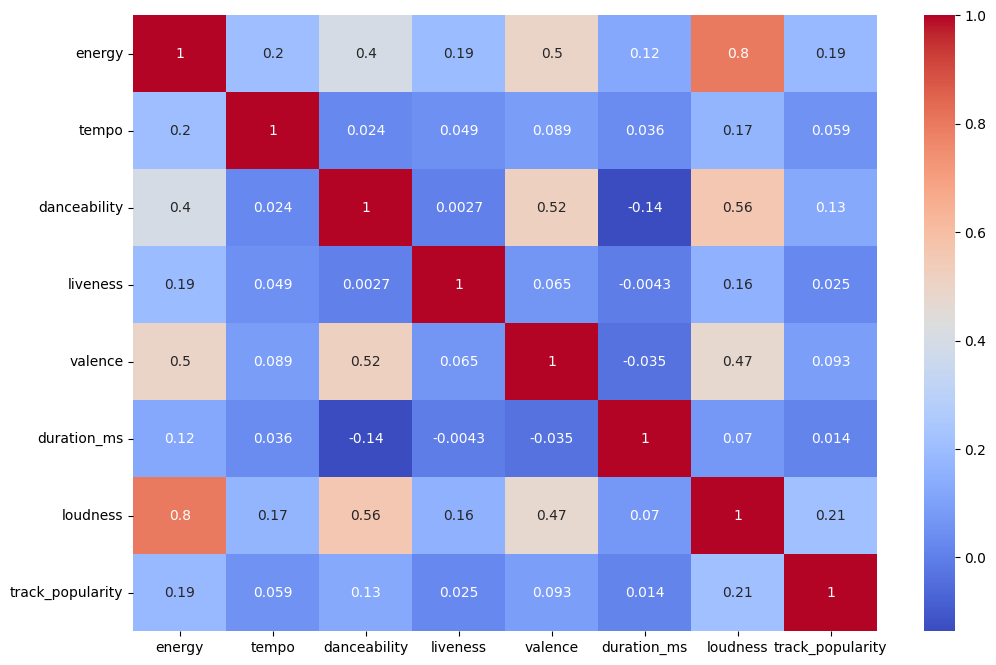

In [23]:
# Plot the heatmap  
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

Energy and Loudness have a high correlation. Will check to see if this commonality is in most popular spotify songs

In [24]:
# used dbbrowser for sqlite to gather most popular song per genre
popular_songs_by_genre = pd.read_csv('max_popular_songs.csv')

In [25]:
# any null values
popular_songs_by_genre.isnull().any().any()

np.False_

In [26]:
popular_songs_by_genre.shape

(37, 6)

In [27]:
# checking for duplicates and removing any duplicated values by genre

duplicates_popular_songs_by_genre = popular_songs_by_genre[popular_songs_by_genre.duplicated(keep=False)]

duplicates_popular_songs_by_genre.shape

(10, 6)

In [28]:
# Drop duplicates and create a new DataFrame
popular_songs_by_genre_no_duplicates = popular_songs_by_genre.drop_duplicates()

popular_songs_by_genre_clean = popular_songs_by_genre_no_duplicates

In [29]:
# Filtering for most popular song by genre in the spotify database (from sql csv)

def filter_by_genre(df, column_name, genre):
    """ Filtering by column genre to find the top song for that genre based on popular spotify data.
    
    Parameters:
    df = The DataFrame that houses the data
    column_name = column that is being filtered
    genre = The genre to search
   
     Returns:
    pandas.DataFrame: A filtered DataFrame containing rows where the genre matches the given genre.
    """
    

    filtered_popular_songs = popular_songs_by_genre_clean[popular_songs_by_genre_clean['playlist_genre'] == genre]
    return filtered_popular_songs



In [30]:
result_popular = filter_by_genre(popular_songs_by_genre, 'playlist_genre', 'jazz')
result_popular

,playlist_genre,track_popularity,track_artist,track_popularity.1,track_name,analysis_url
1,jazz,69,Nat King Cole,69,Unforgettable,https://api.spotify.com/v1/audio-analysis/648T...


In [31]:
popular_songs_by_genre_clean.shape

(32, 6)

In [32]:
# Filtering for most popular song by genre in the spotify database (from sql csv)

def filter_by_genre(df, column_name, genre):
    """ Filtering by column genre to find the top song for that genre based on popular spotify data.
    
    Parameters:
    df = The DataFrame that houses the data
    column_name = column that is being filtered
    genre = The genre to search
   
     Returns:
    pandas.DataFrame: A filtered DataFrame containing rows where the genre matches the given genre.
    """
    

    filtered_popular_songs = popular_songs_by_genre[popular_songs_by_genre['playlist_genre'] == genre]
    return filtered_popular_songs


In [33]:
result_popular = filter_by_genre(popular_songs_by_genre, 'playlist_genre', 'jazz')
result_popular

,playlist_genre,track_popularity,track_artist,track_popularity.1,track_name,analysis_url
1,jazz,69,Nat King Cole,69,Unforgettable,https://api.spotify.com/v1/audio-analysis/648T...


In [34]:
# checking unique genre titles in spotify 

unique_spotify_genres = popular_songs_by_genre_clean['playlist_genre'].unique()

unique_spotify_genres

array(['pop', 'jazz', 'classical', 'hip-hop', 'afrobeats', 'latin',
       'indian', 'country', 'r&b', 'electronic', 'soul', 'gaming',
       'j-pop', 'metal', 'reggae', 'k-pop', 'arabic', 'rock', 'punk',
       'blues', 'folk', 'lofi', 'brazilian', 'turkish', 'ambient',
       'korean', 'world', 'indie'], dtype=object)

In [35]:
# setting up for merge of survey data base and spotify database by creating similar genre titles
survey_db_counts['Favgenre'] = survey_db_counts['Favgenre'].replace('hip hop', 'hip-hop')

In [36]:
# updating column name in survey dataset to match column in spotify 
survey_db_counts = survey_db_counts.rename(columns={'Favgenre': 'playlist_genre'})

In [37]:
# merge of survey and spotify datasets on playlist genre
merged_survey_spotify = pd.merge(survey_db_counts, popular_songs_by_genre_clean, on='playlist_genre')

In [38]:
merged_survey_spotify

,Primarystreamingservice,playlist_genre,improve_count,worsen_count,no_effect_count,total_count,improve_percentage,worsen_percentage,no_effect_percentage,track_popularity,track_artist,track_popularity.1,track_name,analysis_url
0,spotify,classical,17,1,7,25,68.000000,4.00,28.00,75,"Ludovico Einaudi, Daniel Hope, I Virtuosi Ital...",75,Experience,https://api.spotify.com/v1/audio-analysis/1Bnc...
1,spotify,country,12,0,3,15,80.000000,0.00,20.00,73,Kenny Rogers,73,The Gambler,https://api.spotify.com/v1/audio-analysis/5Kql...
2,spotify,folk,15,0,5,20,75.000000,0.00,25.00,93,Gigi Perez,93,Sailor Song,https://api.spotify.com/v1/audio-analysis/2262...
3,spotify,hip-hop,26,0,2,28,92.857143,0.00,7.14,92,"The Weeknd, Playboi Carti",92,Timeless (with Playboi Carti),https://api.spotify.com/v1/audio-analysis/1Es7...
4,spotify,jazz,13,0,2,15,86.666667,0.00,13.33,69,Nat King Cole,69,Unforgettable,https://api.spotify.com/v1/audio-analysis/648T...
5,spotify,latin,0,0,1,2,0.000000,0.00,50.00,93,"Oscar Maydon, Fuerza Regida",93,Tu Boda,https://api.spotify.com/v1/audio-analysis/1cOb...
6,spotify,latin,0,0,1,2,0.000000,0.00,50.00,93,KAROL G,93,Si Antes Te Hubiera Conocido,https://api.spotify.com/v1/audio-analysis/6Wat...
7,spotify,lofi,8,0,0,8,100.000000,0.00,0.00,73,"Kina, Snøw",73,Get You The Moon (feat. Snøw),https://api.spotify.com/v1/audio-analysis/4ZLz...
8,spotify,metal,49,0,12,61,80.327869,0.00,19.67,83,System Of A Down,83,Chop Suey!,https://api.spotify.com/v1/audio-analysis/2DlH...
9,spotify,pop,52,2,14,68,76.470588,2.94,20.59,100,"Lady Gaga, Bruno Mars",100,Die With A Smile,https://api.spotify.com/v1/audio-analysis/2plb...


In [39]:
# creating function that will read in audio files to be used in function for waveforms for plots


# Function to read audio file as binary data
def read_audio_file(file_path):
    with open(file_path, 'rb') as f:
        return f.read()

# List of audio file paths
audio_paths = ['classical.wav', 'country.wav', 'folk.wav', 'hip_hop.wav', 'jazz.wav', 'latin.wav', 'lofi.wav', 'metal.wav', 'pop.wav', 'r&b.wav', 'rock.wav']

# Create lists to hold data
file_names = []
audio_data = []

# Loop through file paths to read data
for path in audio_paths:
    file_names.append(path)
    audio_data.append(read_audio_file(path))

# Create DataFrame
audio_spotify = pd.DataFrame({'audio_file': file_names, 
                   'audio_data': audio_data})


print(audio_spotify)

       audio_file                                         audio_data
0   classical.wav  b'RIFF\xa0\xe4\xa3\x03WAVEfmt \x10\x00\x00\x00...
1     country.wav  b'RIFFF\x00;\x02WAVEfmt \x10\x00\x00\x00\x01\x...
2        folk.wav  b'RIFFF\xd0:\x02WAVEfmt \x10\x00\x00\x00\x01\x...
3     hip_hop.wav  b'RIFF\xb6P\xee\x02WAVEfmt \x10\x00\x00\x00\x0...
4        jazz.wav  b'RIFFF\xa6-\x02WAVEfmt \x10\x00\x00\x00\x01\x...
5       latin.wav  b'RIFF:\xb5=\x02WAVEfmt \x10\x00\x00\x00\x01\x...
6        lofi.wav  b'RIFFF\x86\x9c\x01WAVEfmt \x10\x00\x00\x00\x0...
7       metal.wav  b'RIFFF\x8ei\x02WAVEfmt \x10\x00\x00\x00\x01\x...
8         pop.wav  b'RIFF\xce\x18\xa6\x02WAVEfmt \x10\x00\x00\x00...
9         r&b.wav  b'RIFFf\xa0\x1c\x02WAVEfmt \x10\x00\x00\x00\x0...
10       rock.wav  b'RIFFFPK\x02WAVEfmt \x10\x00\x00\x00\x01\x00\...


In [40]:

# Creating a function that will read the audio files as binary data so that they are able to plot as waveforms


def waveform(df, audiofile):
    """
    Generates and plots the waveform of an audio file.

    This function filters an audio file based on its name and generates a 
    waveform for the selected audio file.

    Parameters:
    df (pandas.DataFrame): The DataFrame that houses the data, typically containing audio file paths.
    audiofile (str): The name of the audio file to be processed (e.g., "classical.wav").

    Returns:
    None: This function plots the waveform of the audio file.
    """

    # Ensure the audiofile exists in the DataFrame
    if audiofile not in df['audio_file'].values:
        print(f"{audiofile} not found in the DataFrame!")
        return

    # Check if the file has a valid extension
    if not audiofile.lower().endswith('.wav'):
        print("This function currently only handles WAV files.")
        return
    
    # Load the audio file
    try:
        with wave.open(audiofile, 'rb') as wav_file:
            # Get parameters (sample width, frame rate, number of frames, etc.)
            params = wav_file.getparams()
            n_channels = params[0]
            sample_width = params[1]
            frame_rate = params[2]
            n_frames = params[3]
            
            # Read the audio frames
            audio_data = wav_file.readframes(n_frames)
            
            # Convert audio data to numpy array
            audio_array = np.frombuffer(audio_data, dtype=np.int16)

    except Exception as e:
        print(f"Error loading audio file {audiofile}: {e}")
        return

    # If stereo (2 channels), split the channels (use the first channel for simplicity)
    if n_channels == 2:
       audio_array = audio_array[::2]  # Take just one channel for simplicity

    # Time axis for plotting (in seconds)
    time = np.linspace(0, n_frames / frame_rate, num=n_frames)

    # Plot the waveform
    plt.figure(figsize=(8, 2))
    plt.plot(time, audio_array)
    plt.title(f"Waveform of {audiofile}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()

# Example usage (assuming you have a DataFrame 'df' containing your audio file paths)
audio_path = ['classical.wav', 'country.wav', 'folk.wav', 'hip_hop.wav', 'jazz.wav', 'latin.wav', 'lofi.wav', 'metal.wav', 'pop.wav', 'r&b.wav', 'rock.wav']
audio_popular = pd.DataFrame({'audio_file': file_names, 
                   'audio_data': audio_data})




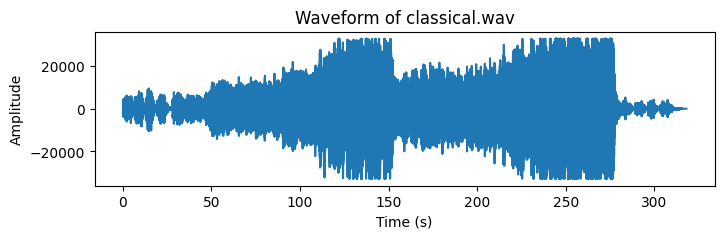

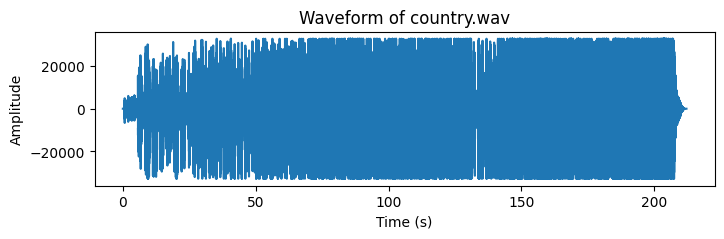

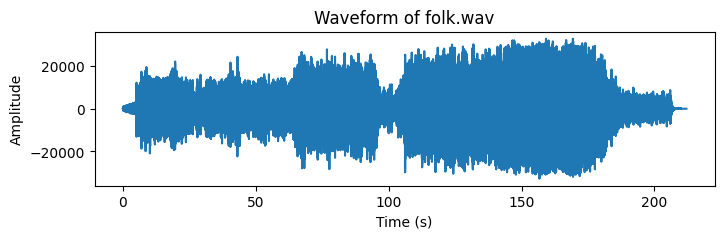

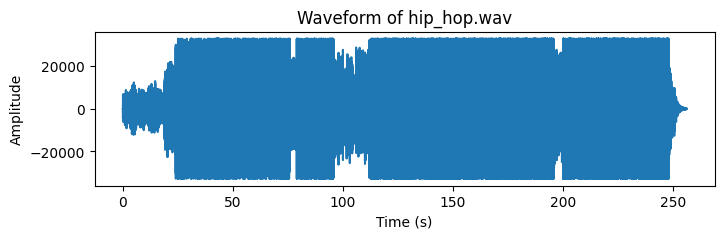

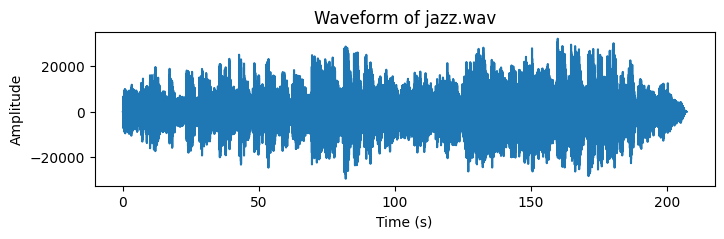

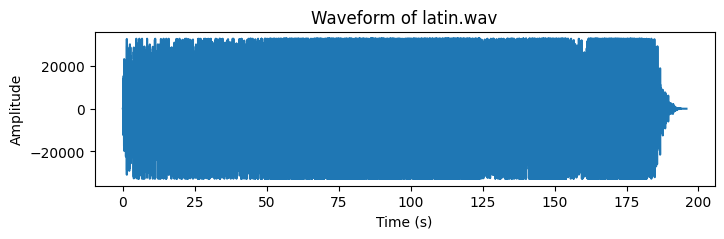

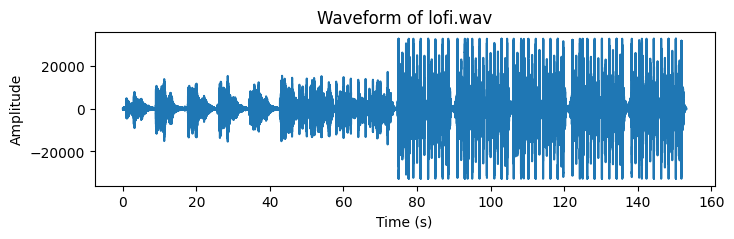

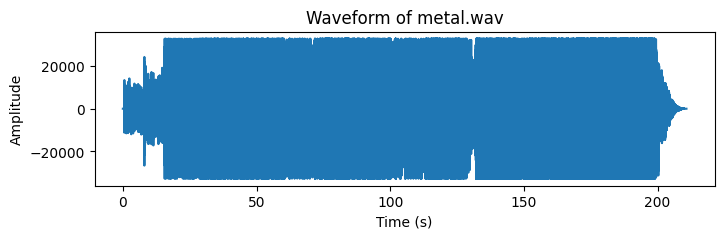

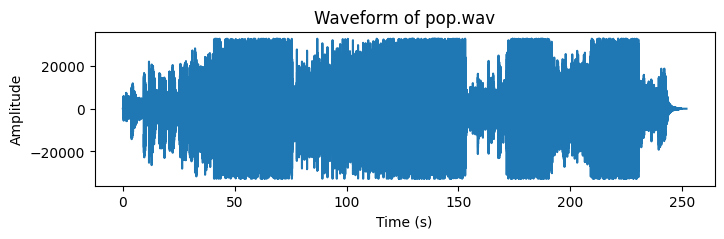

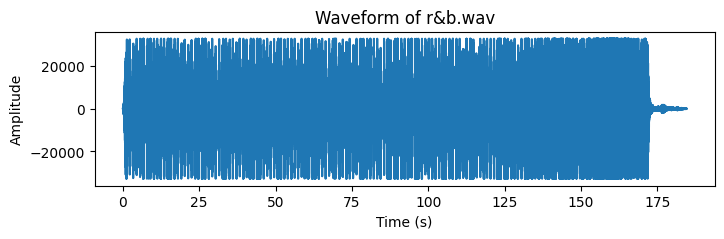

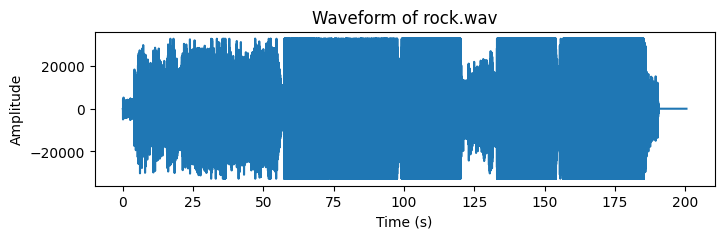

In [41]:
# plotting most popular by genre on spotify waveforms on songs to check if any similarities in music
waveform(audio_popular, 'classical.wav')
waveform(audio_popular, 'country.wav')
waveform(audio_popular, 'folk.wav')
waveform(audio_popular, 'hip_hop.wav')
waveform(audio_popular, 'jazz.wav')
waveform(audio_popular, 'latin.wav')
waveform(audio_popular, 'lofi.wav')
waveform(audio_popular, 'metal.wav')
waveform(audio_popular, 'pop.wav')
waveform(audio_popular, 'r&b.wav')
waveform(audio_popular, 'rock.wav')

In [42]:

def bar(df, x, y):
    """Generates and plots the bar plot of percentages by playlist_genre.

    This function generates a bar plot based on x being playlist genre and y being percentage.

    Parameters:
    df (pandas.DataFrame): The DataFrame that houses the data, containing percentages and playlist genre
    

    Returns:
    None: This function plots the bar."""

# Plotting Improve Percentage by Playlist Genre
    plt.figure(figsize=(8, 4))
    sns.barplot(x=x, y=y, data=df, palette='viridis')  
    plt.title(f'{y} by {x}')
    plt.xlabel(f'{x}')
    plt.ylabel(f'{y}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

/var/folders/sw/mf1x4fnn1jg2jq5n72k6mkm80000gn/T/ipykernel_34989/59657179.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x, y=y, data=df, palette='viridis')


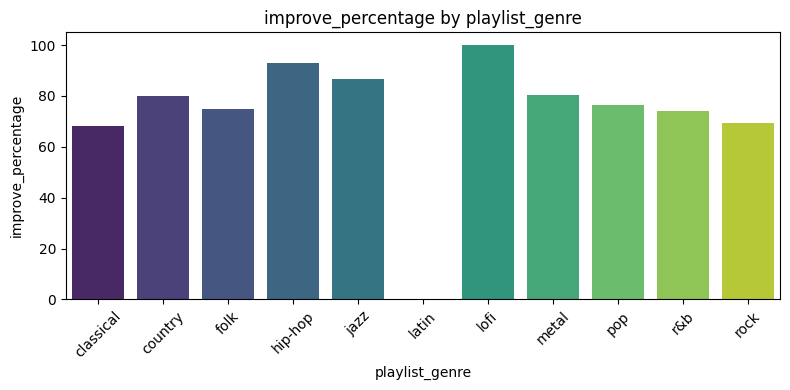

/var/folders/sw/mf1x4fnn1jg2jq5n72k6mkm80000gn/T/ipykernel_34989/59657179.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x, y=y, data=df, palette='viridis')


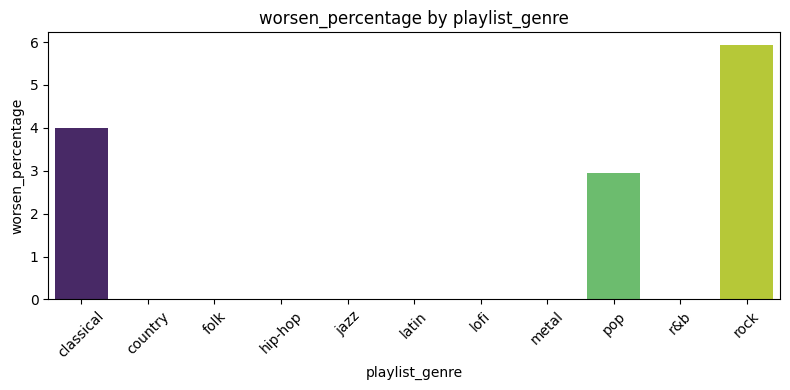

/var/folders/sw/mf1x4fnn1jg2jq5n72k6mkm80000gn/T/ipykernel_34989/59657179.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x, y=y, data=df, palette='viridis')


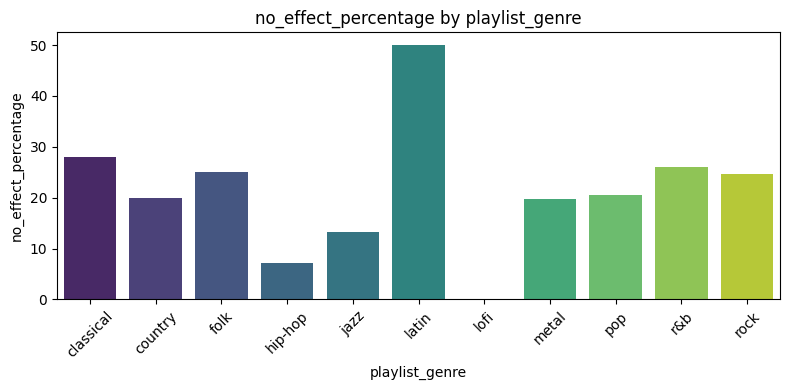

/var/folders/sw/mf1x4fnn1jg2jq5n72k6mkm80000gn/T/ipykernel_34989/59657179.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x, y=y, data=df, palette='viridis')


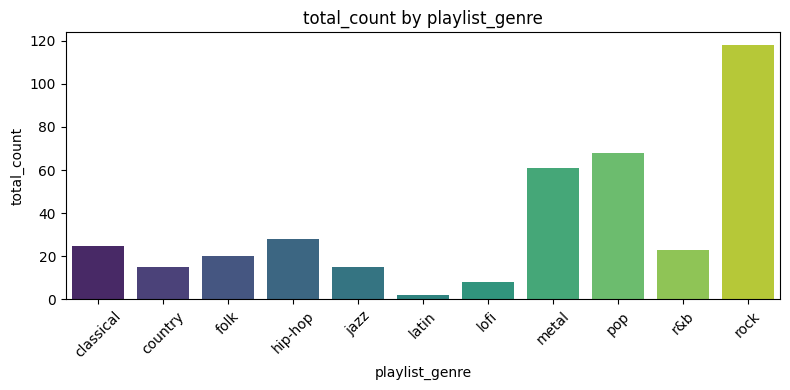

/var/folders/sw/mf1x4fnn1jg2jq5n72k6mkm80000gn/T/ipykernel_34989/59657179.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x, y=y, data=df, palette='viridis')


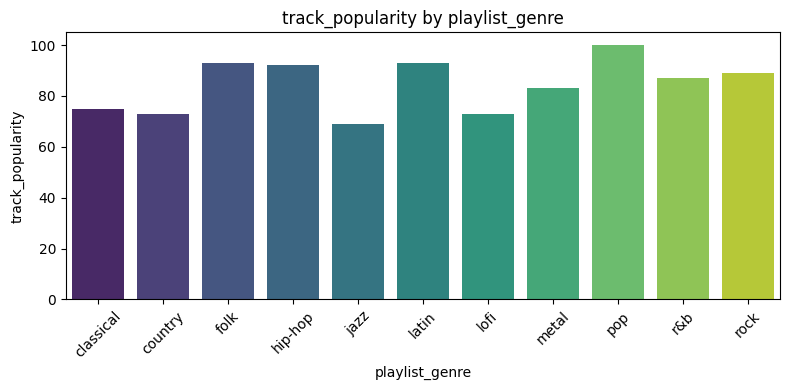

In [43]:
bar(merged_survey_spotify, 'playlist_genre', 'improve_percentage')
bar(merged_survey_spotify, 'playlist_genre', 'worsen_percentage')
bar(merged_survey_spotify, 'playlist_genre', 'no_effect_percentage')
bar(merged_survey_spotify, 'playlist_genre', 'total_count')
bar(merged_survey_spotify, 'playlist_genre', 'track_popularity')

### Most Popular by genre on spotify 

- Classical *Experience, Ludovico Einaudi*

 <audio controls>
        <source src="classical.wav" type="audio/wav">
        Your browser does not support the audio element.
      </audio>


- Country *The Gambler, Kenny Rogers*

<audio controls>
        <source src="country.wav" type="audio/wav">
        Your browser does not support the audio element.
      </audio>


- Folk *Sailor Song, Gigi Perez*

<audio controls>
        <source src="folk.wav" type="audio/wav">
        Your browser does not support the audio element.
      </audio>


- Hip Hop *Timeless, The Weeknd, Playboi Carti*

<audio controls>
        <source src="hip_hop.wav" type="audio/wav">
        Your browser does not support the audio element.
      </audio>


- Jazz *Unforgettable, Nat King Cole*

<audio controls>
        <source src="jazz.wav" type="audio/wav">
        Your browser does not support the audio element.
      </audio>


- Latin *Si antes te hubiera conocido, Karol G* (could only locate one of the two latin songs)

<audio controls>
        <source src="latin.wav" type="audio/wav">
        Your browser does not support the audio element.
      </audio>


- Lofi *Get you the Moon, Kina feat Snow* (Trigger Warning)

<audio controls>
        <source src="lofi.wav" type="audio/wav">
        Your browser does not support the audio element.
      </audio>


- Metal *Chop Suey, System of a down* (Trigger Warning)

<audio controls>
        <source src="metal.wav" type="audio/wav">
        Your browser does not support the audio element.
      </audio>


- Pop *Die with a Smile, Lady Gaga and Bruno Mars*

<audio controls>
        <source src="pop.wav" type="audio/wav">
        Your browser does not support the audio element.
      </audio>


- R&B *Pink + White, Frank Ocean*

<audio controls>
        <source src="r&b.wav" type="audio/wav">
        Your browser does not support the audio element.
      </audio>


- Rock *The Emptiness Machine, Linkin Park* 

<audio controls>
        <source src="rock.wav" type="audio/wav">
        Your browser does not support the audio element.
      </audio>
